In [36]:
# Imports
import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt

import RandomForestTools

%matplotlib inline

In [8]:
# Get the data
train_df = pd.read_csv("data/train.csv", dtype={"Age": np.float64}, )
test_df = pd.read_csv("data/test.csv", dtype={"Age": np.float64}, )

In [14]:
# We know the embarked keyword only has a few entries, so let's go ahead and split that.
test_df = test_df.join(pd.get_dummies(test_df.Embarked, prefix="Embarked"))
train_df = train_df.join(pd.get_dummies(train_df.Embarked, prefix="Embarked"))

# Also split sex now
test_df = test_df.join(pd.get_dummies(test_df.Sex, prefix="Sex"))
train_df = train_df.join(pd.get_dummies(train_df.Sex, prefix="Sex"))

In [15]:
# Drop the duplicate data and columns we don't care about
test_df.drop(["Embarked", "Sex",'Sex_female', 'Name','Ticket',"Cabin"], axis=1, inplace=True)
train_df.drop(["Embarked", "Sex",'Sex_female', 'Name','Ticket',"Cabin"], axis=1, inplace=True)

In [19]:
# We need to fill in Age data. I'm going with setting missing ages to a very negative number so it's clear they 
# are fubar (maybe that's important)
train_df["Age"].fillna(-100, inplace=True)
test_df["Age"].fillna(-100, inplace=True)

median_fare = train_df['Fare'].median(axis=0)
train_df["Fare"].fillna(median_fare, inplace=True)
test_df["Fare"].fillna(median_fare, inplace=True)

In [52]:
# Restrict to what we care about
y_train = train_df["Survived"]
X_train = train_df[["Pclass", "Age","SibSp", "Parch", "Fare","Embarked_C","Embarked_S","Embarked_Q","Sex_male"]]
X_test =  test_df[["Pclass", "Age","SibSp", "Parch", "Fare","Embarked_C","Embarked_S","Embarked_Q","Sex_male"]]

In [53]:
# We need to normalize our features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_test_scaled = pd.DataFrame(sc.fit_transform(X_test))
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train))
X_test_scaled.columns = X_test.columns
X_train_scaled.columns = X_train.columns

In [54]:
# Do a quick Random Forest Classifier to see what features seem to be most important
from sklearn.ensemble import RandomForestClassifier
feat_labels = X_train_scaled.columns
forest = RandomForestClassifier(n_estimators=1000, random_state=69, n_jobs=-1)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=69, verbose=0, warm_start=False)

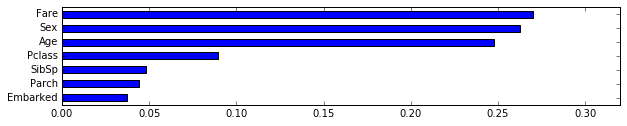

In [55]:
RandomForestTools.graph_feature_importances(forest, X_train.columns, summarized_columns=["Embarked", "Sex"])

From this, just like with random forrest regression (odd, right?) we find that the most important factors are Fare, Sex, Age, and Pclass.

In [56]:
X_train_trimmed = forest.transform(X_train_scaled, threshold=0.05)
X_test_trimmed = forest.transform(X_test_scaled, threshold=0.05)

/Users/rcool/soft/miniconda3/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/rcool/soft/miniconda3/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [58]:
# Proceed to some SVC fitting
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=100.0, gamma=0.1, random_state=69)

In [80]:
# Determine optimal training data set size (n_estimator)
from sklearn.learning_curve import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=svm, X=X_train_trimmed, y=y_train, 
                                                       train_sizes=np.linspace(0.1, 1.0, 25), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

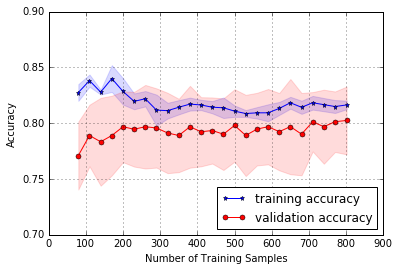

In [79]:
plt.plot(train_sizes, train_mean, color='blue', marker='*', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='red', marker='o', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.14, color='red')
plt.grid()
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim(0.7, 0.9)
plt.show()

In [82]:
# Now, let's look at the C parameter. The C paramter is the regularlization parameter.
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]  # values of C
train_scores, test_scores = validation_curve(estimator=svm, X=X_train_trimmed, y=y_train, 
                                            param_name='C', param_range = param_range, cv=10)


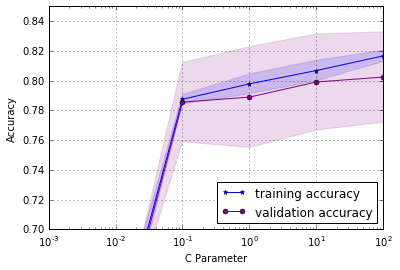

In [87]:
# calculate some stats
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)

plt.plot(param_range, train_mean, marker='*', markersize=5, color='blue',label='training accuracy')
plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, marker='o', markersize=5, color='purple', label='validation accuracy')
plt.fill_between(param_range, test_mean-test_std, test_mean+test_std, alpha=0.15, color='purple')
plt.ylim(0.7, 0.85)
plt.xscale('log')
plt.grid()
plt.xlabel("C Parameter")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')

In [89]:
# Use these values to derive the best parameters for the fit
from sklearn.grid_search import GridSearchCV
param_grid = [{'C':param_range, 
               'kernel': ['linear']},
              {'C' : param_range, 
              'gamma': param_range,
              'kernel' : ['rbf']}]
gs = GridSearchCV(estimator=svm, 
                 param_grid=param_grid, 
                 scoring='accuracy', 
                 cv=10, n_jobs=-1)
gs = gs.fit(X_train_trimmed, y_train)
print(gs.best_score_)

0.82379349046


In [90]:
# Let's see what those parameters are:
print(gs.best_params_)

{'kernel': 'rbf', 'gamma': 10.0, 'C': 1.0}


In [91]:
# Let's do some mock testing with the training set
from sklearn.cross_validation import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_train_trimmed, y_train, test_size=0.25, random_state=69)

In [97]:
# Run on our subsample
svm = SVC(kernel='rbf', C=1.0, gamma=10.0, random_state=69)
svm.fit(X_tr, y_tr)

# Run predictions on our fake subsample
y_pred = svm.predict(X_te)
no_samples = len(y_te)
print("Missclassified Samples %d of %d" %
      ((y_te != y_pred).sum(), no_samples))

from sklearn.metrics import accuracy_score
print("Accuracy: %.2f" % accuracy_score(y_te, y_pred))

Missclassified Samples 41 of 223
Accuracy: 0.82


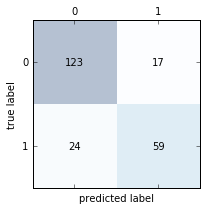

In [103]:
# Let's see the classification matrix
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_te, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, 
               s=confmat[i,j], 
                va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')

In [106]:
# final model
svm = SVC(kernel='rbf', C=1.0, gamma=10, random_state=69)
svm.fit(X_train_trimmed, y_train)

y_pred = svm.predict(X_test_trimmed)

161

In [108]:
output = test_df.PassengerId
output = pd.DataFrame(output)
predict = pd.DataFrame(y_pred)
output = output.join(predict)
output.columns = ["PassengerId", "Survived"]

In [109]:
output.to_csv("SVC_output.csv", index=False)

This wasn't an improvement over my last submission (Random Forest regression)